# Сегментация пользователей банка по потреблению

## Общие положения. <a id="step1"></a>    

**Заказчик** - менеджер продукта.

**Цель исследования** - разделить клиентов на N категорий для персонализации продуктовых предложений в дальнейшем. 

**Исходные данные** - датасет с данными о клиентах банка.

**Вопросы, которые интересуют заказчика:**

- Сегменты клиентов, их основные характеристики;
- Различия дохода между клиентами, которые пользуются одним и двумя продуктами;
- Рекомендации для дальнейшего взаимодейтвия с клиентами из разных сегментов.

**Основные шаги:**

1. [Общие положения.](#step1)
2. [Изучение общей информации из файлов.](#step2)
3. [Предобработка данных.](#step3)
4. [Исследовательский анализ данных.](#step4)
5. [Сегментация пользователей.](#step5)
6. [Проверка статических гипотез.](#step6)
7. [Выводы и рекомендации.](#step7)


- <a href="https://drive.google.com/file/d/1JE1I0wdsOlM_K6vXDZZ750lD65qYhxiM/view?usp=sharing">Ссылка на презентацию</a>
- <a href="https://public.tableau.com/views/Bank_segmentation/Bank_segmentation?:language=en-US&:display_count=n&:origin=viz_share_link">Дашборд.</a>


## Изучение общей информации из файла. <a id="step2"></a>    

### Получение данных

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep') 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

Прочитаем файл и сохраним его в переменной.

In [2]:
try:
    bank_data = pd.read_csv('/datasets/bank_dataset.csv')
except:
    bank_data = pd.read_csv('bank_dataset.csv')

Объявим функцию `info()` для получения информации о данных.

In [3]:
def info(data):
    print('Первые 5 строк таблицы:')
    display(data.head())
    print('Размер таблицы:')
    display(data.shape)
    print('Общая информация о данных в таблице:')
    display(data.info())
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    print('Количество пропущенных значений:')
    display(data.isna().sum())

Изучим таблицу `bank_data`.

In [4]:
info(bank_data)

Первые 5 строк таблицы:


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Размер таблицы:


(10000, 12)

Общая информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Количество дубликатов:


0

Количество пропущенных значений:


userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

**Таблица `bank_data`**:
- `userid` — идентификатор пользователя, тип данных - `int64`;
- `score` — баллы кредитного скоринга, тип данных - `int64`;
- `City` — город, тип данных - `object`;
- `Gender` — пол, тип данных - `object`;
- `Age` — возраст, тип данных - `int64`;
- `Objects` — количество объектов в собственности, тип данных - `int64`;
- `Balance` — баланс на счёте, тип данных - `float64`;
- `Products` — количество продуктов, которыми пользуется клиент, тип данных - `int64`;
- `CreditCard` — есть ли кредитная карта (1 - есть кредитная карта), тип данных - `int64`;
- `Loyalty` — активный клиент (1 - активный), тип данных - `int64`;
- `estimated_salary` — заработная плата клиента, тип данных - `object64`;
- `Churn` — ушёл или нет (1 - отток), тип данных - `int64`.

### Выводы

Таблица `bank_data` содержит 10000 наблюдений и 12 полей. Встречаются следующие типы данных: 8 столбцов с типом данных `int64`, 1 в формате `float64`, 3 столбца с типом данных `object64`.
Проблемы, которые нужно решить: пропущенные значения в столбце `Balance`, разный регистр названия столбцов.
Дубликатов нет. Тип данных менять не нужно.

## Предобработка данных. <a id="step3"></a>    

### Изменение названия столбцов

Для удобства приведем названия колонок к нижнему регистру. Проверим результат.

In [5]:
bank_data.columns = bank_data.columns.str.lower()
bank_data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Обработка пропусков

Исследование регулярное и, видимо, на момент выгрузки данных на дебетовом счете клиента `balance` не было денежных средств, либо данный счет у него отсутствует. C NaN можно проводить математические операции, так как тип данных - `float`. Оставим пропуски без заполнения характерными значениями. Замена этих значений на среднее, медиану может повлиять на результаты исследования.

### Выводы

Мы переимоновали столбцы для удобства дальнейшей работы и оставили пропуски без заполнения для проведения корректного исследования.

## Исследовательский анализ данных. <a id="step4"></a>    

### Расчет средних значений и стандартных отклонений признаков

Изучим средние значения и стандартные отклонения признаков.

In [6]:
bank_data.drop(['userid'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.0,650.528800,96.653299,350.00,584.000,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.000,37.000,44.0000,92.00
objects,10000.0,5.012800,2.892174,0.00,3.000,5.000,7.0000,10.00
balance,6383.0,119827.493793,30095.056462,3768.69,100181.975,119839.690,139512.2900,250898.09
products,10000.0,1.530200,0.581654,1.00,1.000,1.000,2.0000,4.00
creditcard,10000.0,0.705500,0.455840,0.00,0.000,1.000,1.0000,1.00
loyalty,10000.0,0.515100,0.499797,0.00,0.000,1.000,1.0000,1.00
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.110,100193.915,149388.2475,199992.48
churn,10000.0,0.203700,0.402769,0.00,0.000,0.000,0.0000,1.00


Из таблицы мы видим, что:
- кредитный рейтинг пользователей варьируется от 350 до 850 у.е., (стандартное отклонение высокое, что говорит о существенном разбросе в данных); 
- средний возраст клиента - 39 лет, не более 25% клиентов возрастом старше 44 лет (стандартное отклонение высокое, что говорит о существенном разбросе в данных);
- в среднем клиент владеет 5 объектами собственности, есть клиенты без собственности (стандартное отклонение высокое, что говорит о существенном разбросе в данных);
- нет клиентов без банковских продуктов;
- средняя заработная плата - 100 090 у.е. (стандартное отклонение высокое, что говорит о существенном разбросе в данных);
- отток клиентов - 20,4% (вероятно, под оттоком подразумевается отказ от использования одним продуктом, а не уход, так как клиентов без банковских продуктов в датасете нет).

### Распределение признаков 

Посмотрим на распределение количественных признаков.

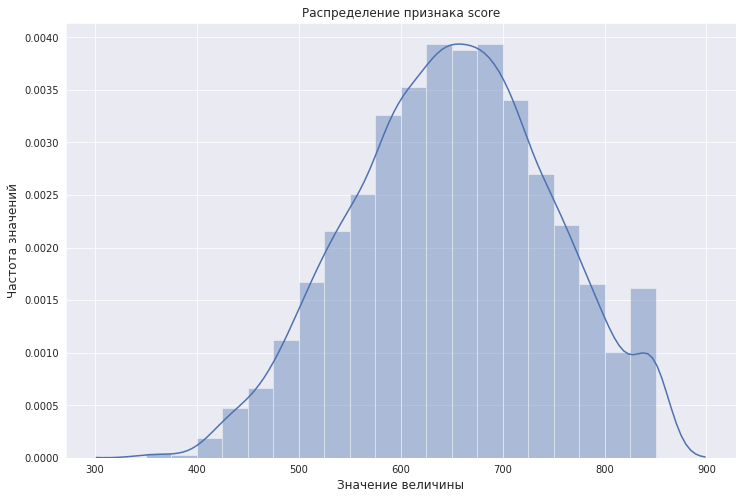

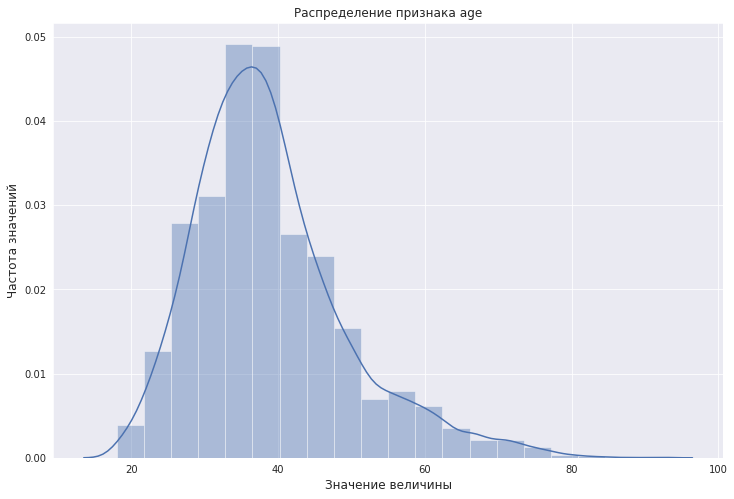

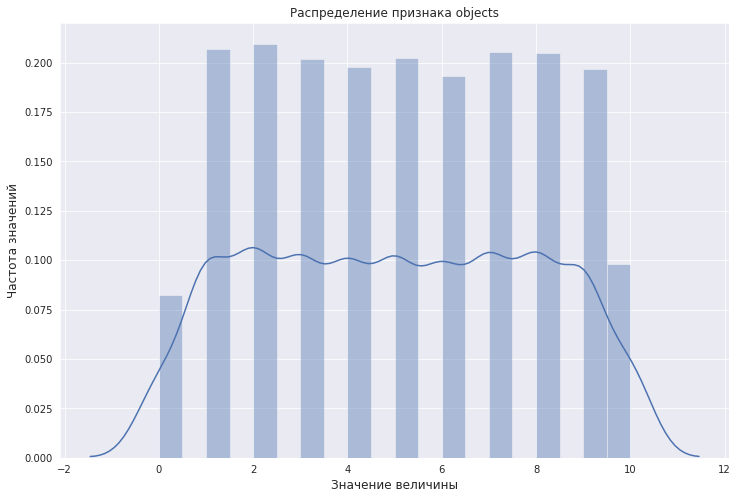

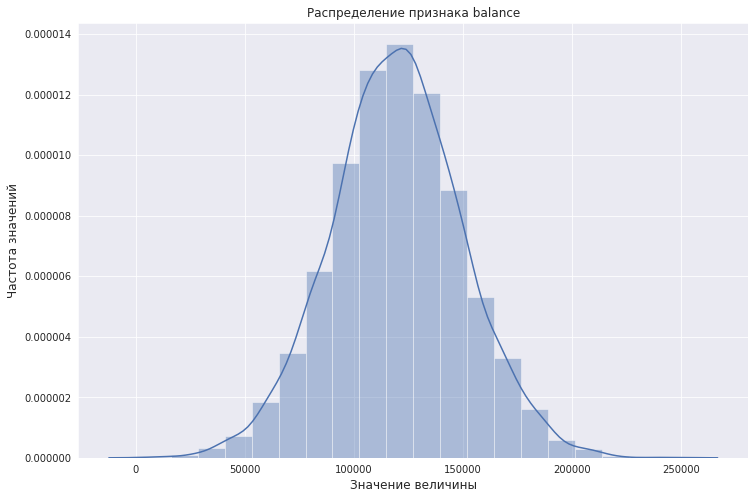

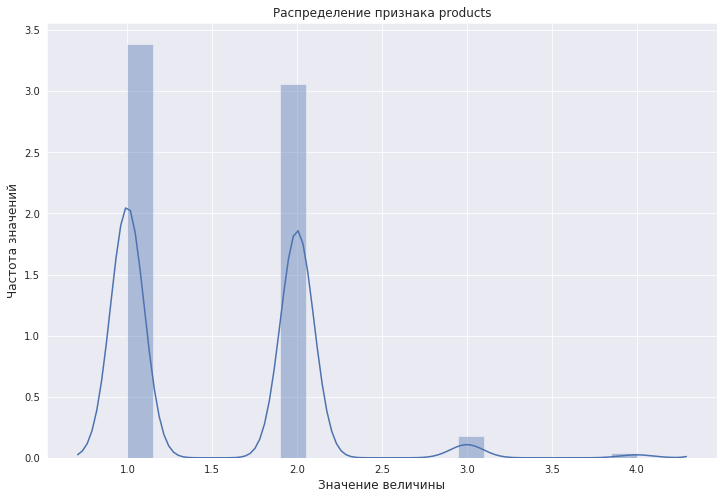

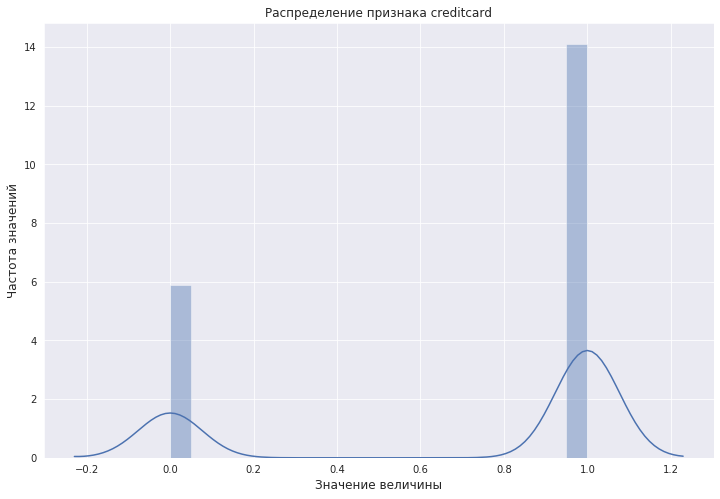

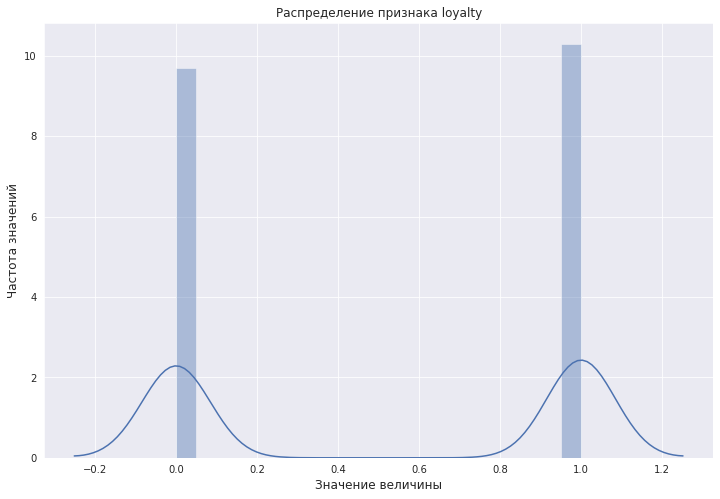

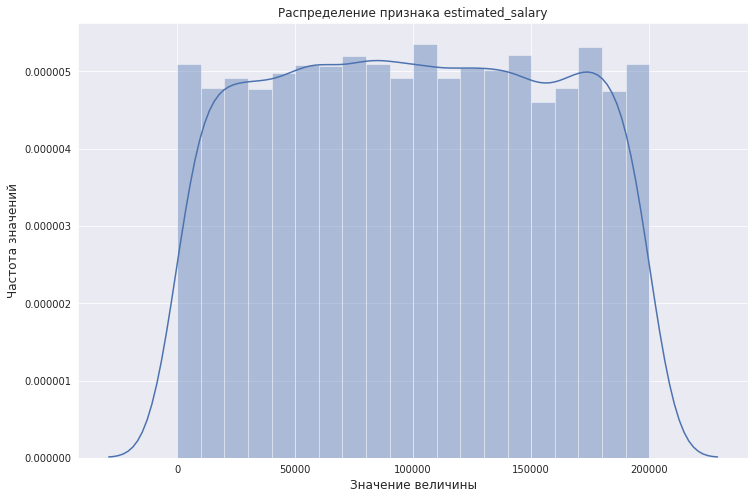

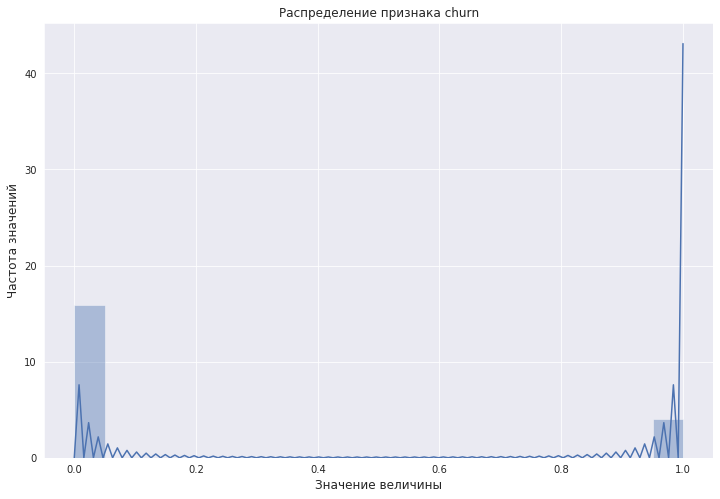

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 45em; }</style>"))

for i in bank_data.drop(['userid','gender','city'], axis = 1).columns:
    sns.set_style('darkgrid')
    plt.figure(figsize = (12, 8))
    sns.distplot(bank_data[i], bins = 20)
    
    plt.title('Распределение признака {}'.format(i))
    plt.xlabel('Значение величины', fontsize = 12)
    plt.ylabel('Частота значений', fontsize = 12)
    plt.show()

На графиках мы видим, что:
-  разброс по заработной плате довольно большой, при этом в данных приблизитено одинаковое число клиентов с разными уровнями зарплаты;
- активных и не активных клиентов практически поровну;
- клиентов с кредитной картой более чем в два раза больше, чем без нее;
- в большинстве своем клиенты пользуются 1 или 2 продуктами;
- разброс по балансу дебетовой карты довольно большой;
- клиенты с 1 - 9 объектами собственности встречаются практически в одиноковой степени часто, меньше всего клиентов без собственности или с 10 объектами;
- клиентский возраст составляет в среднем 34-40 лет, видим длинный хвост на высоких значениях;
- в среднем у клиентов банка 650 баллов кредитного скоринга, значения данного показателя распределены нормально, сильных выбросов нет. 

Посмотрим на количество банковских продуктов в категориях `city`, `gender`.

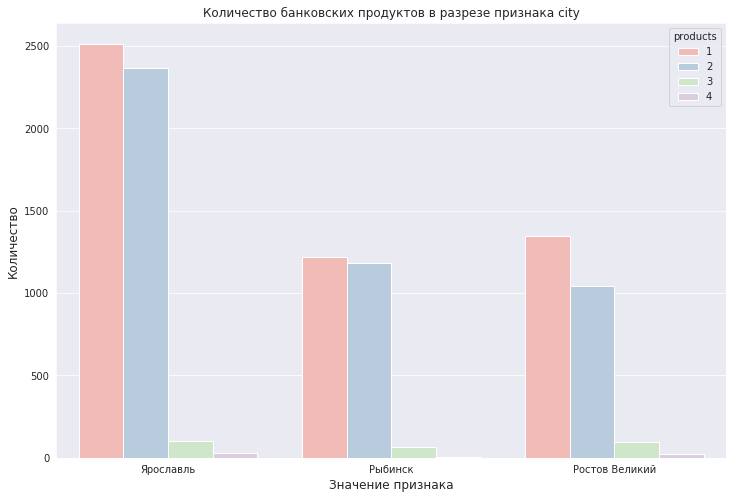

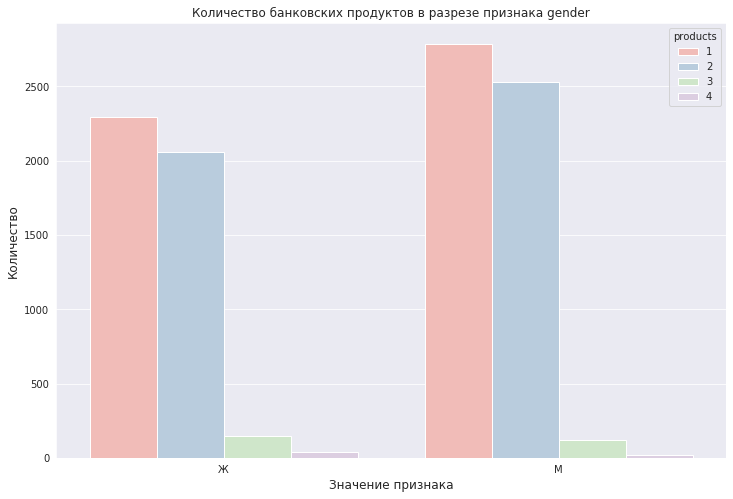

In [8]:
for i in bank_data[['city','gender']].columns:
    sns.set_style('darkgrid')
    plt.figure(figsize = (12, 8))
    sns.countplot(x = i, hue = 'products', data = bank_data, palette = 'Pastel1') 
    
    plt.title('Количество банковских продуктов в разрезе признака {}'.format(i))
    plt.xlabel('Значение признака', fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    plt.show()

На графиках мы видим, что:
- половина клиентов обслуживается в Ярославле, города Ростов Великий и Рыбинск имеют практически одинаковое количество клиентов;
- мужская аудитория в банке представлена в большем размере чем женская.

### Диаграммы совместного распределения

Построим диаграммы совместного распределения количественных признаков в разрезе оттока клиентов.

Text(0.5, 1.05, 'Совместное распределение количественных признаков в разрезе churn')

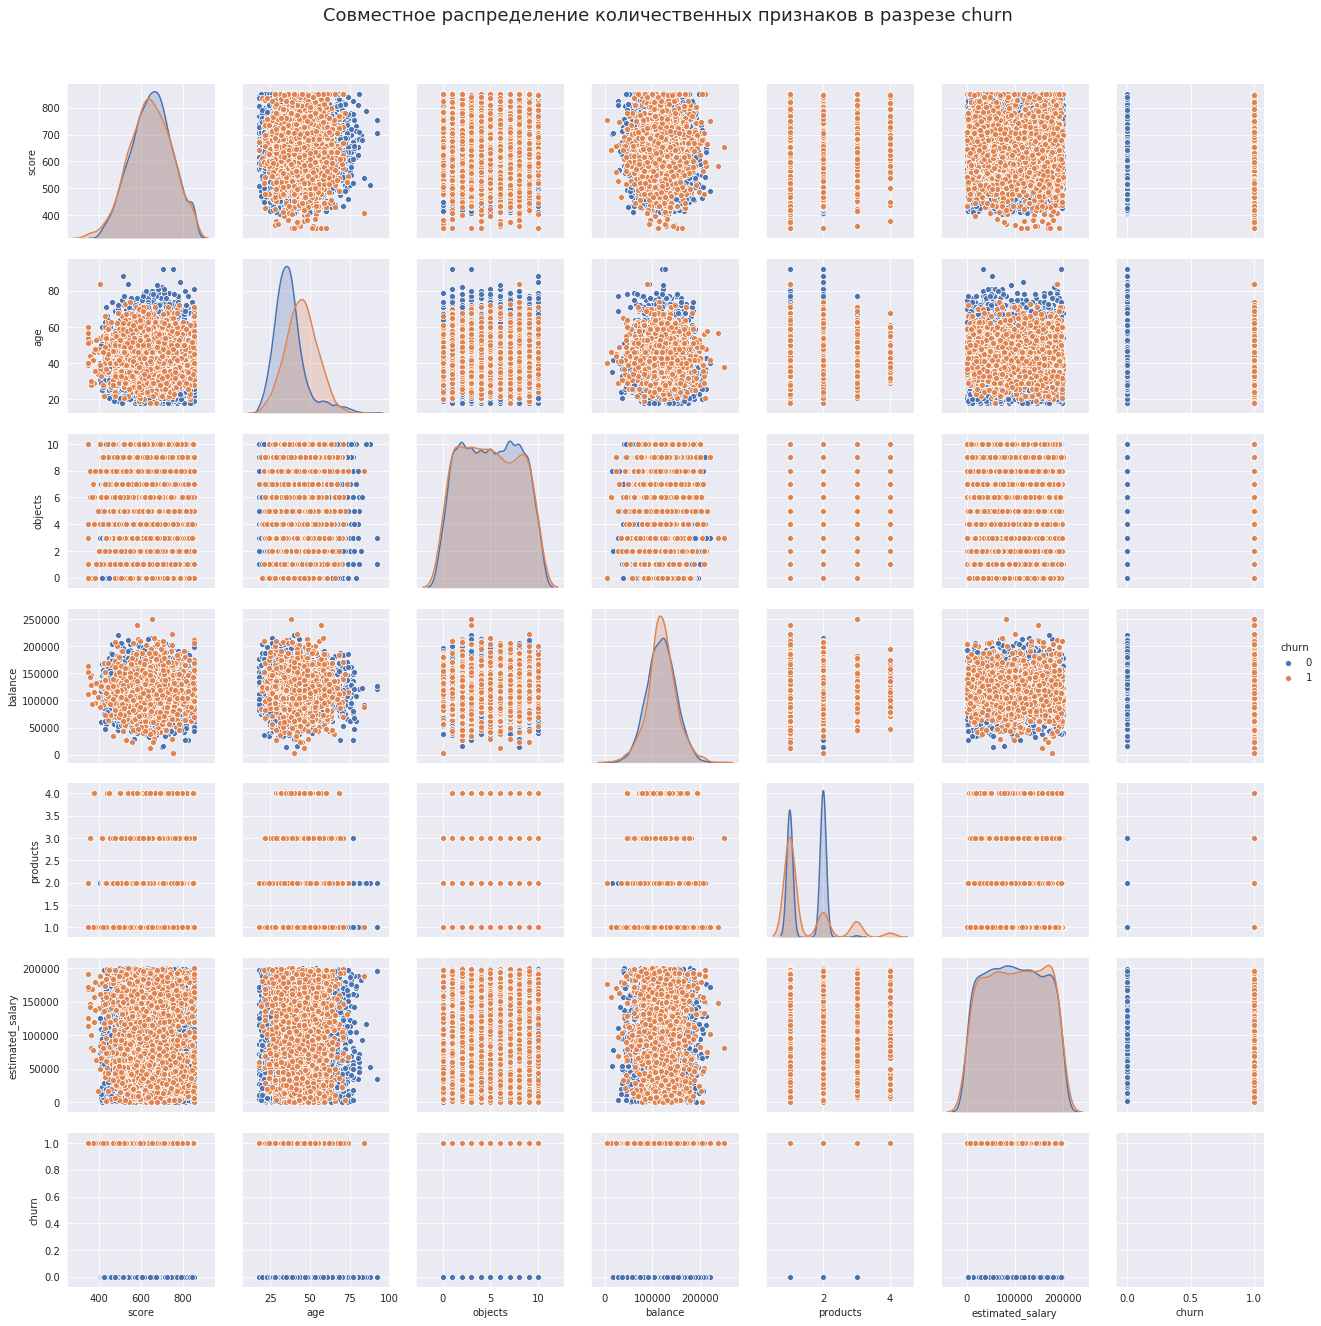

In [9]:
sns.set_style('darkgrid')
sns.pairplot(bank_data[['score', 'age', 'objects', 'balance', 'products', 'estimated_salary', 'churn']], \
             hue = 'churn')

plt.suptitle('Совместное распределение количественных признаков в разрезе churn', y = 1.05, size = 18)

На графиках мы видим, что в отток попадают клиенты с меньшим количеством баллов кредитного скоринга, более возрастные клиенты, которые пользуются преимущесвенно 1 банковским продуктом.

### Матрица корреляции признаков

Построем матрицу корреляций и отобразим её.

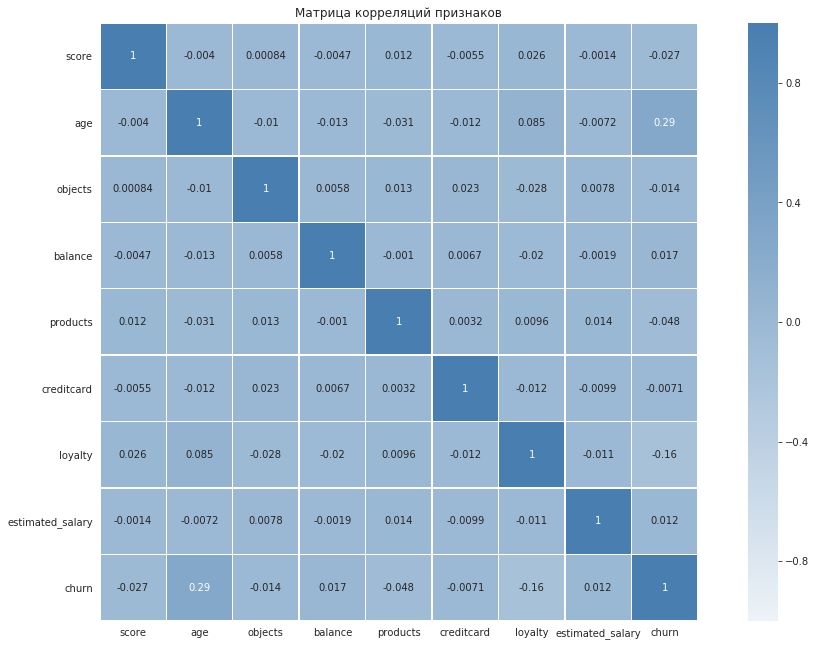

In [10]:
# сохраним матрицу корреляций в переменную cm
cm = bank_data.drop('userid', axis = 1).corr()

# тепловая карта
cmap = sns.light_palette('#487eb0', as_cmap=True)
plt.figure(figsize = (18, 11))

sns.heatmap(cm, center=0, annot=True, linewidths=.5, cmap=cmap, vmin=-1, vmax=1, square=True)

plt.title('Матрица корреляций признаков', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

По матрице мы видим, что взаимосвязь признаков отсутсвует. Есть лишь небольшая положительная корреляция между возрастом `age` и оттоком `churm`, небольшая отрицательная корреляция между активностью клиента `loyalty` и оттоком `churm`.

### Выводы

Среднему клиенту банка "Метанпром" 39 лет. В половине случаев он мужчина из Ярослявля с заработной платой в районе 100 090 у.е. и 5 объектами собственности. У него 650 баллов кредитного скоринга. У него 1 или 2 банковских продукта, преимущественно один из которых - кредитная карта. 

На текущий момент отток составляет 20.4 %. В рамках исследовательского анализа данных мы узнали, что наибольшее влияние на показатель оттока оказывает возраст и активность клиента. С увеличением возраста растет вероятность, что клиент перестанет пользоваться услугами банка. Тоже самое может произойти в связи со снижением активности клиента.

## Сегментация пользователей.<a id="step5"></a>    

### Выделение групп на основе данных о количестве потребляемых продуктов

Разобьем пользователей на 4 группы по количеству потребляемых продуктов и изучим их подробнее.

In [11]:
bank_data.drop('userid', axis =1).groupby('products').mean().reset_index()

,products,score,age,objects,balance,creditcard,loyalty,estimated_salary,churn
0,1,649.120968,39.673092,4.974626,119894.163723,0.703777,0.504131,99487.256851,0.277144
1,2,652.188671,37.753595,5.051852,119660.944362,0.707190,0.532898,100452.012821,0.075817
2,3,648.105263,43.195489,5.003759,119475.686310,0.714286,0.424812,104318.130564,0.827068
3,4,653.583333,45.683333,5.300000,122260.610870,0.683333,0.483333,104763.723333,1.000000


Не считая показателя оттока, возраста группы по всем признакам похожи.

У клиентов с 4-мя продуктами в среднем больше объектов имущества, выше балланс на дебетовом счете, они реже остальных используют кредитные карты, у них выше средний доход и ниже активность. Это самая возрастная группа - средний возраст 45 лет. Отток в этой группе - 100%. 

У клиентов с 3-мя продуктами средний возраст 43 года, самый высокий процент оттока - 82,7%.

У клиентов с 2-мя продуктами средний возраст 37 лет, самый низкий процент оттока - 7,5%.

У клиентов с 1 продуктом средний возраст 39 лет, в среднем меньше всего объектов собственности, наибольшая активность, процент оттока - 27,7%.

Для каждой группы посчитайем количество пользователей.

In [12]:
number_of_users = bank_data.groupby('products')['userid'].count()
number_of_users

products
1    5084
2    4590
3     266
4      60
Name: userid, dtype: int64

Группы сильно различаются по количеству пользователей. Клиентов с 1 и 2-мя продуктами больше всего. На их фоне пользователи с 3-мя и 4-мя продуктами почти незначительны. 100% отток в 4 группе - это всего лишь 1% клиентов от группы 1.

### Распределение признаков 

Посмотрим на распределение признаков в группах.

In [13]:
list_1 = ['creditcard', 'loyalty', 'churn', 'city', 'gender']
list_2 = ['age', 'balance', 'estimated_salary', 'objects', 'score']

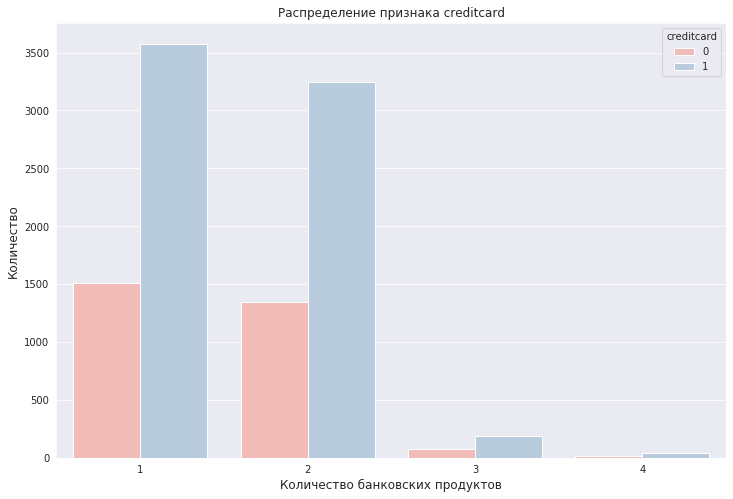

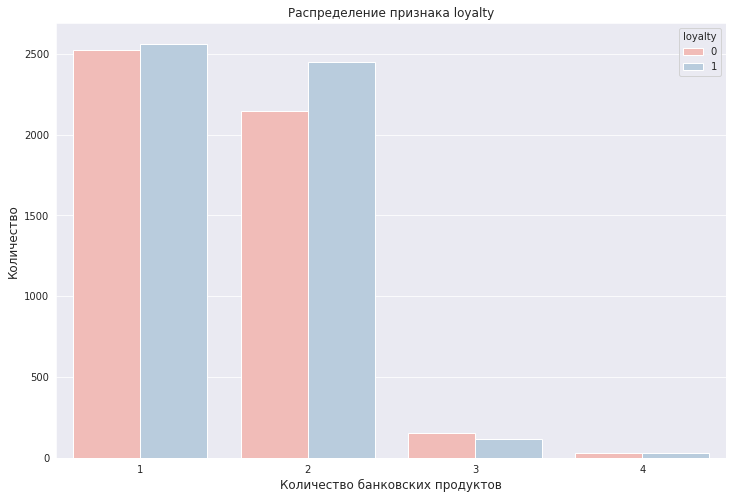

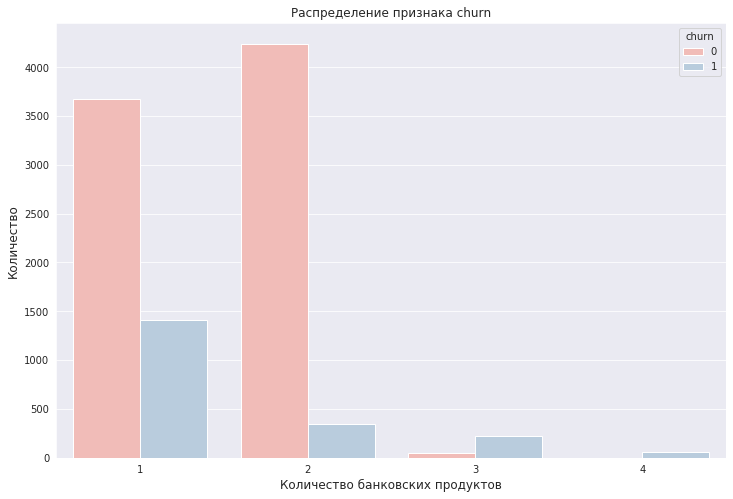

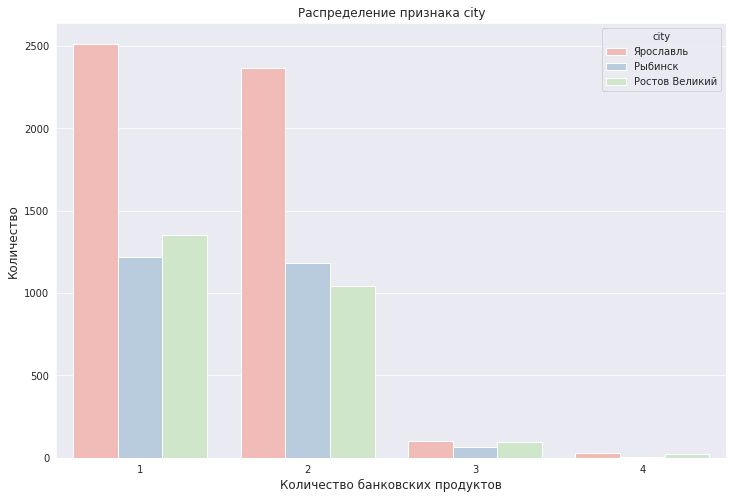

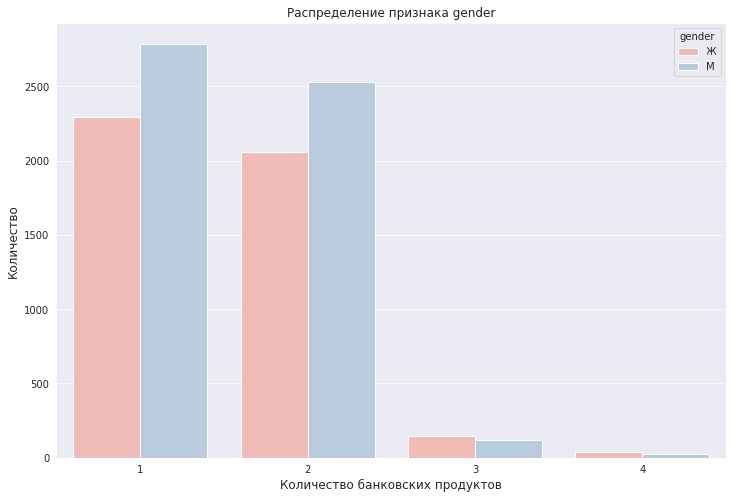

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))

for i in list_1:
    sns.set_style('darkgrid')
    plt.figure(figsize = (12, 8))
    sns.countplot(data = bank_data, x = 'products', hue = i, palette = 'Pastel1')
    
    plt.title('Распределение признака {}'.format(i), fontsize = 12)
    plt.xlabel('Количество банковских продуктов', fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    plt.show()

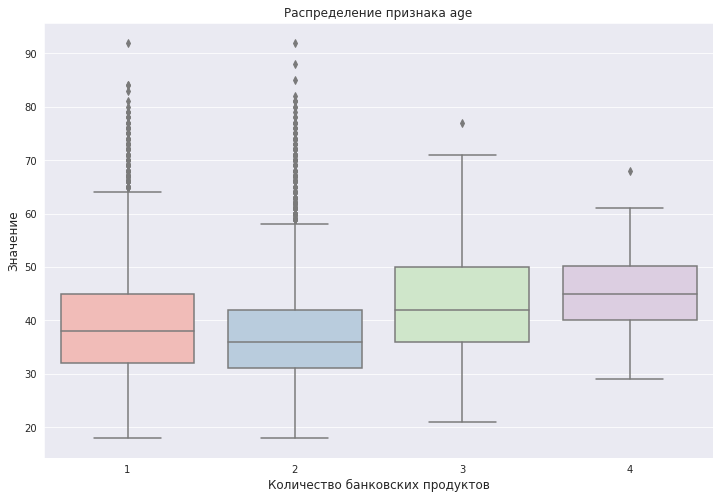

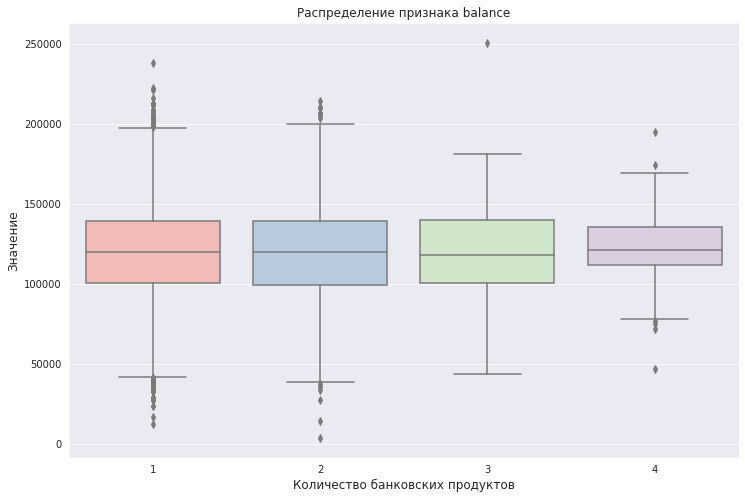

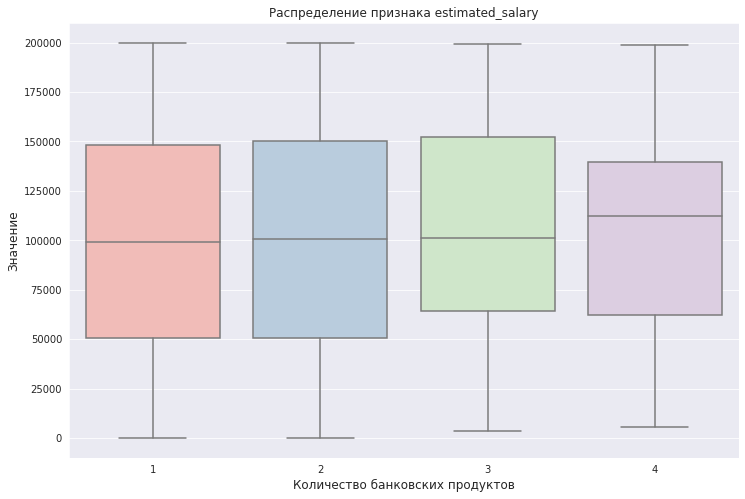

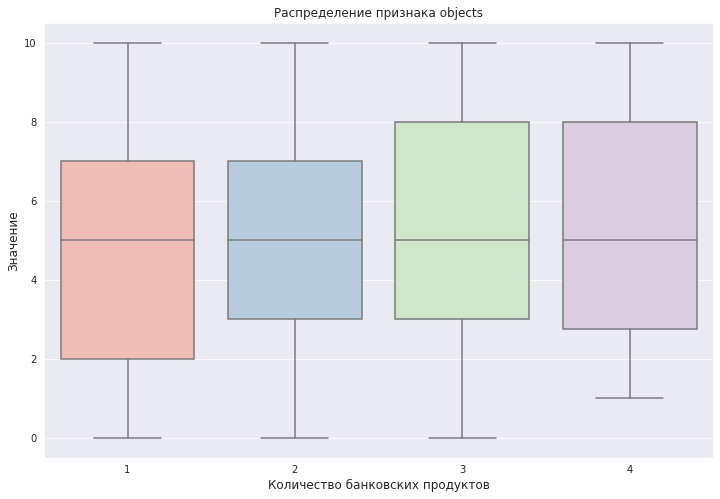

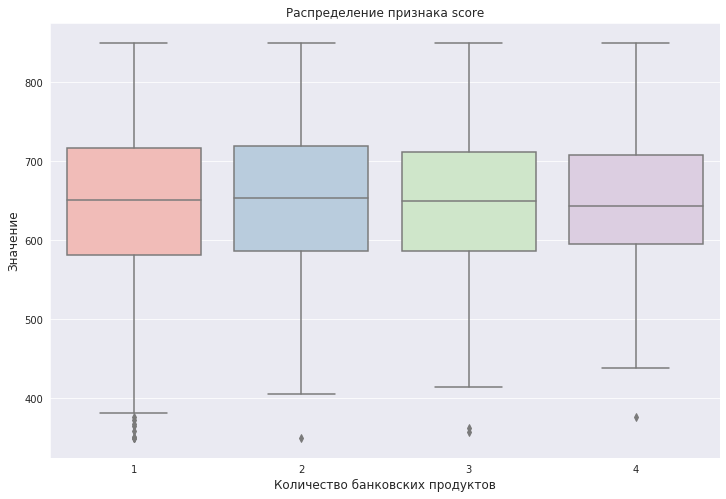

In [15]:
for i in list_2:
    sns.set_style('darkgrid')
    plt.figure(figsize = (12, 8))
    sns.boxplot(x ='products', y = i, data = bank_data, palette = 'Pastel1')
    
    plt.title('Распределение признака {}'.format(i), fontsize = 12)
    plt.xlabel('Количество банковских продуктов', fontsize = 12)
    plt.ylabel('Значение', fontsize = 12)
    plt.show()

### Выводы

**Первая группа (1 банковский продукт):**

Данная группа самая многочисленная (5084 человека) и обладает характеристиками среднего пользователя. В большей степени это активные клиенты мужского пола со средним возрастом 39 лет, 5 объектами собственности, кредитной картой. У них 649 баллов кредитного скоринга и заработная плата в районе 99 500 у.е. Таких клиентов больше в Ярославле и Ростове Великом. Отток - 27,7%.

**Вторая группа (2 банковских продукта):**

Данная группа вторая по величине (4590 человек) и отличается от остальных тем, что клиенты в ней более молодые. Средний возраст - 37 лет и в общей массе возраст не превышает 42 года. В большей степени это активные клиенты мужского пола с 5 объектами собственности, кредитной картой. У них 652 балла кредитного скоринга и заработная плата в районе 100 450 у.е. Таких клиентов больше в Ярославле и Рыбинске. Отток - 7,5%.

**Третья группа (3 банковских продукта):**

В данной группе 266 человек. В большей степени это неактивные клиенты женского пола со средним возрастом 43 года с 5 объектами собственности, кредитной картой. У них 648 баллов кредитного скоринга и заработная плата в районе 104 300 у.е. Таких клиентов больше в Ярославле и Ростове Великом. Отток - 82,7%.

**Четвертая группа (4 банковских продукта):**
В данной группе 60 человек. Клиенты данной группы самые возрастные - средний возраст 45 лет и нет клиентов младше 40, преимущественно женского пола. В этой группе самые высокие показатели заработной платы и количества денежных средств на дебетовом счете. Отток - 100%.

Были замечены закономерности между возратом, количеством используемых банковских продуктов, полом клиентов и их лояльностью (оттоком). Проверим наши гипотезы.

## Проверка статических гипотез.<a id="step6"></a>    

### Различия дохода между клиентами, которые пользуются одним и двумя продуктами

Сформулируем **нулевую гипотезу H₀**: доход клиентов с одним банковским продуктом равен доходу клиентов с двумя банковскими продуктами. Сформулируем **альтернативную гипотезу H₁**: доход клиентов с одним банковским продуктом не равен доходу клиентов с двумя банковскими продуктами.

Проверим данные на нормальность.

In [16]:
#Функция для выполнения теста Шапиро-Уилка на нормальность распределения выборок.
def shapiro(А, В):
    '''
    Нулевая гипотеза: распределение нормальное.
    Альтернативная гипотеза: распределение не нормальное.
    '''
    alpha_shapiro =  0.05
    
    shapiro_test1 = st.shapiro(А)
    shapiro_test2 = st.shapiro(В)
    
    print('1_p-значение', shapiro_test1[1], '\n2_p-значение', shapiro_test2[1])
    
    if shapiro_test1[1] < alpha_shapiro and shapiro_test2[1] < alpha_shapiro:
        print('Отвергаем нулевую гипотезу, распределение не нормальное.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, распределение нормальное.')

In [17]:
shapiro(bank_data.query('products == 1')['estimated_salary'], bank_data.query('products == 2')['estimated_salary'])

1_p-значение 3.017243029368968e-36 
2_p-значение 2.1702207154579243e-35
Отвергаем нулевую гипотезу, распределение не нормальное.


Распределение доходов клиентов не нормальное по обоим группам, поэтому для проверки гипотезы воспользуемся непараметрическим тестом Манна-Уитни.

In [18]:
#Функция для проверки гипотезы тестом Уилкоксона-Манна-Уитни
def mannwhitneyu(А, В):
    
    alpha_mannwhitneyu =  0.05
    
    results = st.mannwhitneyu(А, В)
    
    print('p-значение', results.pvalue)
    
    if results.pvalue < alpha_mannwhitneyu:
        print('Отвергаем нулевую гипотезу, разница статистически значима.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.')

In [19]:
mannwhitneyu(bank_data.query('products == 1')['estimated_salary'], bank_data.query('products == 2')['estimated_salary'])

p-значение 0.20397833259638254
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


### Различия баллов кредитного скоринга для ушедших и оставшихся клиентов

Сформулируем **нулевую гипотезу H₀**: показатели баллов кредитного скоринга равны для ушедших и оставшихся клиентов. Сформулируем **альтернативную гипотезу H₁**: показатели баллов кредитного скоринга не равны для ушедших и оставшихся клиентов.

Проверим данные на нормальность.

In [20]:
shapiro(bank_data.query('churn == 1')['score'], bank_data.query('churn == 0')['score'])

1_p-значение 1.2323278042458696e-07 
2_p-значение 1.469723138650797e-19
Отвергаем нулевую гипотезу, распределение не нормальное.


Распределение баллов кредитного скоринга не нормальное по обоим группам, поэтому для проверки гипотезы воспользуемся непараметрическим тестом Манна-Уитни.

In [21]:
mannwhitneyu(bank_data.query('churn == 1')['score'], bank_data.query('churn == 0')['score'])

p-значение 0.00993433058636417
Отвергаем нулевую гипотезу, разница статистически значима.


### Различия в возрасте для ушедших и оставшихся клиентов

Сформулируем **нулевую гипотезу H₀**: возраст клиентов, попавших в отток равен возрасту оставшихся клиентов. Сформулируем **альтернативную гипотезу H₁**: возраст клиентов, попавших в отток не равен возрасту оставшихся клиентов. 

Проверим данные на нормальность.

In [22]:
shapiro(bank_data.query('churn == 1')['age'], bank_data.query('churn == 0')['age'])

1_p-значение 0.005956501234322786 
2_p-значение 0.0
Отвергаем нулевую гипотезу, распределение не нормальное.


Распределение возраста клиентов не нормальное по обоим группам, поэтому для проверки гипотезы воспользуемся непараметрическим тестом Манна-Уитни.

In [23]:
mannwhitneyu(bank_data.query('churn == 1')['age'], bank_data.query('churn == 0')['age'])

p-значение 1.6052007159685838e-230
Отвергаем нулевую гипотезу, разница статистически значима.


### Различия в количестве банковских продуктов для ушедших и оставшихся клиентов

Сформулируем **нулевую гипотезу H₀**: клиенты, попавшие в отток пользуются равным количеством банковских продуктов с оставшимися клиентами. Сформулируем **альтернативную гипотезу H₁**: клиенты, попавшие в отток пользуются разным количеством банковских продуктов с оставшимися клиентами. 

Проверим данные на нормальность.

In [24]:
shapiro(bank_data.query('churn == 1')['products'], bank_data.query('churn == 0')['products'])

1_p-значение 0.0 
2_p-значение 0.0
Отвергаем нулевую гипотезу, распределение не нормальное.


Распределение количества банковских продуктов не нормальное по обоим группам, поэтому для проверки гипотезы воспользуемся непараметрическим тестом Манна-Уитни.

In [25]:
mannwhitneyu(bank_data.query('churn == 1')['products'], bank_data.query('churn == 1')['products'])

p-значение 0.4999934727385464
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


### Различия в количестве банковских продуктов для женщин и мужчин

Сформулируем **нулевую гипотезу H₀**: клиенты женского пола пользуются равным количеством банковских продуктов с клиентами мужского пола. Сформулируем **альтернативную гипотезу H₁**: клиенты женского пола пользуются разным количеством банковских продуктов с клиентами мужского пола. 

Проверим данные на нормальность.

In [26]:
shapiro(bank_data.query('gender == "Ж"')['products'], bank_data.query('gender == "М"')['products'])

1_p-значение 0.0 
2_p-значение 0.0
Отвергаем нулевую гипотезу, распределение не нормальное.


Распределение клиентов не нормальное по обоим группам, поэтому для проверки гипотезы воспользуемся непараметрическим тестом Манна-Уитни.

In [27]:
mannwhitneyu(bank_data.query('gender == "Ж"')['products'], bank_data.query('gender == "М"')['products'])

p-значение 0.09939868340407931
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.


### Выводы

Мы провели проверку гипотезы, которую сформулировали перед началом иссследования и ряд проверок гипотез на статистически значимые различия между параметрами для клиентов, которые ушли из банка, и клиентов, которые продолжают пользоваться услугами. В результате были установлены статистические различия между клиентами по баллам кредитного скоринга и возрасту. Нет статистических различий между клиентами по количеству используемых банковских продуктов и полу.

## Выводы и рекомендации.<a id="step7"></a>    

**Выводы**:

В ходе работы мы провели исследование пользователей банка "Метанпром", который располагается в городах: Ростов Великий, Ярославль, Рыбинск. Перед нами была поставлена задача сегментировать пользователей на основе количества используемых банковских продуктов.

1. Средний пользователь банка - это активный клиент мужского пола из Ярославля в возрасте 34-40 лет с заработной платой 100 090 у.е., который пользуется 1-2 банковскими продуктами (включая кредитную карту), владеет несколькими объектами собственности, у него 650 баллов кредитного скоринга.

2. Были выделены следующие сегменты пользователей:

**Первая группа (1 банковский продукт):**

Данная группа самая многочисленная (5084 человека) и обладает характеристиками среднего пользователя. В большей степени это активные клиенты мужского пола со средним возрастом 39 лет, 5 объектами собственности, кредитной картой. У них 649 баллов кредитного скоринга и заработная плата в районе 99 500 у.е. Таких клиентов больше в Ярославле и Ростове Великом. Отток - 27,7%.

**Вторая группа (2 банковских продукта):**

Данная группа вторая по величине (4590 человек) и отличается от остальных тем, что клиенты в ней более молодые. Средний возраст - 37 лет и в общей массе возраст не превышает 42 года. В большей степени это активные клиенты мужского пола с 5 объектами собственности, кредитной картой. У них 652 балла кредитного скоринга и заработная плата в районе 100 450 у.е. Таких клиентов больше в Ярославле и Рыбинске. Отток - 7,5%.

**Третья группа (3 банковских продукта):**

В данной группе 266 человек. В большей степени это неактивные клиенты женского пола со средним возрастом 43 года с 5 объектами собственности, кредитной картой. У них 648 баллов кредитного скоринга и заработная плата в районе 104 300 у.е. Таких клиентов больше в Ярославле и Ростове Великом. Отток - 82,7%.

**Четвертая группа (4 банковских продукта):**
В данной группе 60 человек. Клиенты данной группы самые возрастные - средний возраст 45 лет и нет клиентов младше 40, преимущественно женского пола. В этой группе самые высокие показатели заработной платы и количества денежных средств на дебетовом счете. Отток - 100%.

Отметим, что сегментация сегментация клиентов банка на основае количества потребляемых продуктов недостаточна. Сильных различий в группах выявить не удалось (только на основе возраста). Необходимо обсудить с менеджером продукта возможность предоставления для анализа более подробной выборки клиентов с финансовыми, социальными и демографическими признаками в разрезе времени. 

3. Была проведена проверка статических гипотез, подтверждающая влияние количества баллов кредитного скоринга, возраста на отток клиентов и не подтверждающая влияние количества используемых продуктов и пола клиента на отток.

|N|Гипотеза|  р-value | Результаты проверки|
|:---:|:--------|:--------:|:--------:|
|1|Доход клиентов с одним банковским продуктом равен доходу клиентов с двумя банковскими продуктами|0.204|Подтверждена| 
|2|Показатели баллов кредитного скоринга равны для ушедших и оставшихся клиентов|0.009|Не подтверждена|
|3|Возраст клиентов, попавших в отток равен возрасту оставшихся клиентов|0.000|Не подтверждена|
|4|Клиенты, попавшие в отток пользуются равным количеством банковских продуктов с оставшимися клиентами|0.499|Подтверждена|
|5|Клиенты женского пола пользуются равным количеством банковских продуктов с клиентами мужского пола|0.099|Подтверждена|

**Рекомендации**:

1. Стоит изучить причины оттока клиентов, провести дополнительное исследование. 
2. При продвижении продуктов сделать акцент на возраст. Необходимо предлагать продукты с учетом потребностей людей разных возрастов.
3. Более молодым, активным клиентам представить весь спектр банковских продуктов.